In [92]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


Social Predictors of Student Academic Performance

Introduction: 

It is difficult to interpret the true meaning of student grades because there are numerous outside factors that could impact academic performance. We suspect that non-academic factors play a big role in predicting grades. In particular, our project will look at the predictive power of social factors on academic performance. We roughly define a social factor as something that could affect someone's lifestyle or relationships. For this project, we have selected the Student Performance Dataset from the UC Irvine Machine Learning Repository, which outlines student achievements in secondary education of two Portugeuse schools. Through school reports and questionnaires, over 30 attributes were collected ranging from grades, demographic, social and school related aspects. From the two datasets provided for evaluating student performance based on subjects (Portugeuse language and Math), we have selected math as our area of interest. Our goal in this project is to select social factors and evaluate their impact on the students grade in Math, and to determine which ones are most predictive of student grades.

Preliminary Exploratory Data Analysis:


Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.

`summarise()` ungrouping output (override with `.groups` argument)



grade_category,n
<fct>,<int>
poor,32
weak,70
sufficient,125
good,45
very good,16
excellent,10


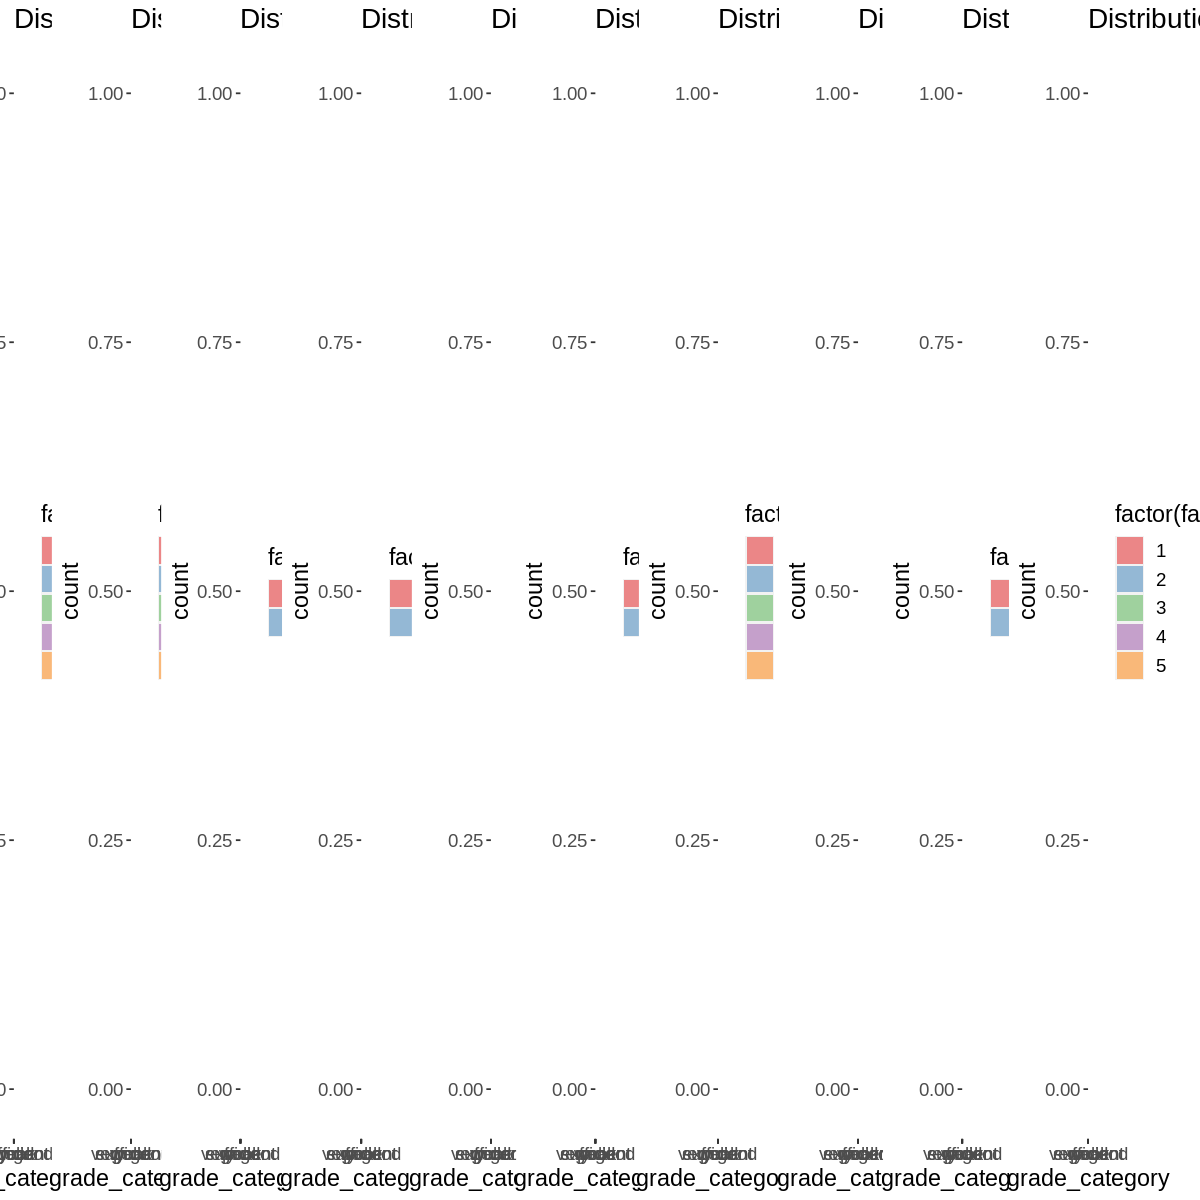

In [93]:
options(repr.plot.width = 10, repr.plot.height = 10)
# download zip file containing student-mat.csv 
url <-"https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

temp <- tempfile()
temp2 <- tempfile()

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
# read csv file containing student academic performance
data_raw <- read_csv2(file.path(temp2, "student-mat.csv"))

unlink(c(temp, temp2))

# select columns corresponding to overall grades and the 10 predictors we have decided to use
data_select_predictors <- data_raw %>%
    select(famsize, Pstatus, Medu, goout, romantic, freetime, Fedu, paid, famsup, famrel, G3)

# convert grades from numerical to categorical data according to the Portugese academic grading system found here:
#https://en.wikipedia.org/wiki/Academic_grading_in_Portugal
grade_cats <- data_select_predictors %>%
    mutate(grade_category = cut(G3, br = c(-1,3.4,9.4,13.4,15.4,17.4,20), labels = c("poor", "weak", "sufficient", "good", "very good",
                                                                                             "excellent"))) %>%
    mutate(romantic_categorized = ifelse(romantic == "yes", 1, 0))

# split data into training and testing data
set.seed(1)
grades_split <- initial_split(grade_cats, prop = 0.75, strata = grade_category)
grades_train <- training(grades_split)
grades_test <- testing(grades_split)
# Table showing distribution of each category of grade in the training dataset
grades_summary <- grades_train %>%
    group_by(grade_category) %>%
    summarize(n = n())

grades_summary

# grade distributions based on father's education level (0 = none, 1 = up to 4th grade, 2 = 5-9th grade, 3 = secondary education, 4 = higher
# education)
edu_plot_father <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(Fedu))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) +
    ggtitle("Distributions of student grades based on Father's Education Level") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on mother's education level
edu_plot_mother <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(Medu))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades based on Mother's Education Level") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
famsize_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(famsize))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades based on Family Size") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
pstatus_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(Pstatus))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Parental Cohabitation Status") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on frequency of going outwith friends (numeric: from 1 - very low to 5 - very high)
goout_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(goout))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Going out Frequency") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on presence/absence of a romantic relationship (binary: yes or no)
romantic_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(romantic))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Romantic Relationship Status") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on free time after school (numeric: from 1 - very low to 5 - very high)
freetime_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(freetime))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Amount of Free Time") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on extra paid classes within the course subject (binary: yes or no)
paid_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(paid))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Presence/Absence of Paid Tutoring") +
    scale_fill_brewer(palette = 'Set1')


# grade distributions based on family educational support (binary: yes or no)
famsup_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(famsup))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Family Educational Support") +
    scale_fill_brewer(palette = 'Set1')

# grade distributions based on quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
famrel_plot <- grades_train %>% 
    ggplot(aes(x = grade_category, fill = factor(famrel))) +
    geom_bar(position = "fill", alpha = 0.5) +
    theme(text = element_text(size = 14)) + 
    ggtitle("Distributions of student grades Based on Quality of Family Relationships") +
    scale_fill_brewer(palette = 'Set1')
# plot bar graphs for each predictor
edu_plot_father
edu_plot_mother
famsize_plot
pstatus_plot
goout_plot
romantic_plot
freetime_plot
paid_plot
famsup_plot
famrel_plot


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7773333,5,0.007483315,Model01
1,roc_auc,hand_till,0.8664000,5,0.004489989,Model01
2,accuracy,multiclass,0.7706667,5,0.006182412,Model02
2,roc_auc,hand_till,0.8776160,5,0.006109296,Model02
3,accuracy,multiclass,0.7106667,5,0.009333333,Model03
3,roc_auc,hand_till,0.8888107,5,0.005594039,Model03
4,accuracy,multiclass,0.6880000,5,0.005734884,Model04
4,roc_auc,hand_till,0.8888320,5,0.006152101,Model04
5,accuracy,multiclass,0.6853333,5,0.020805982,Model05


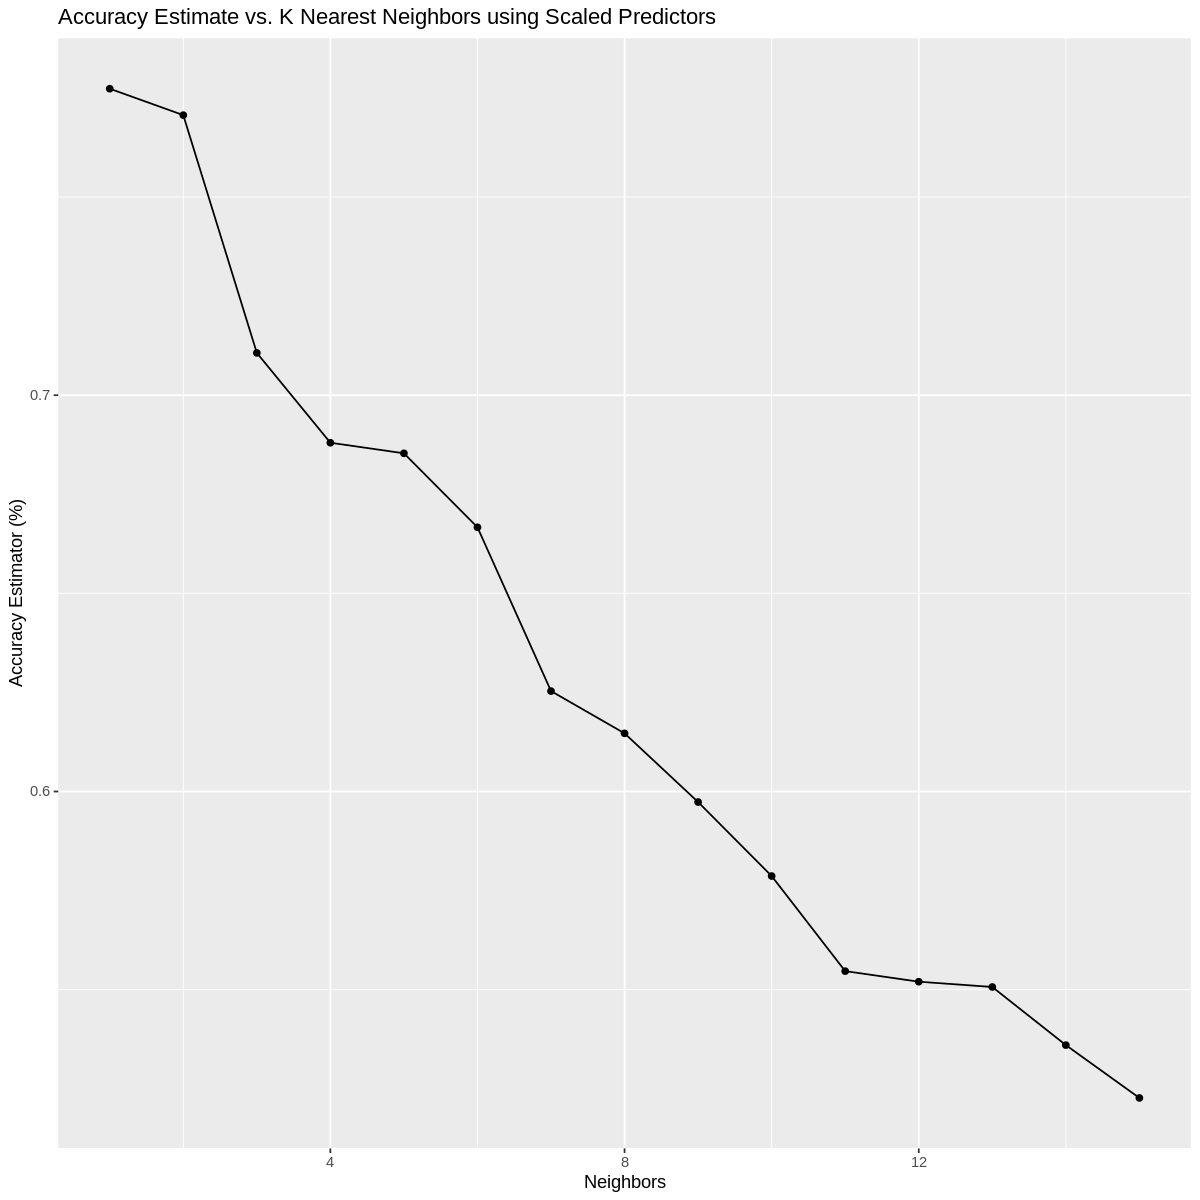

In [86]:
# Workflow using scaled predictors

# predictors to include: Fedu, Medu, goout, romantic, freetime, and famrel; 

grades_train_predictors <- grades_train %>%
    mutate(grade_category = as_factor(grade_category)) %>%
    select(-famsize, -Pstatus, -paid, -famsup, -G3, -romantic)

set.seed(1)

# obtain dataframe for upsampled data
grades_train_predictors <- recipe(grade_category ~., data = grades_train_predictors) %>%
    step_upsample(grade_category, over_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(new_data = grades_train_predictors)

#create recipe
grades_scaled <- recipe(grade_category ~., data = grades_train_predictors) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors()) %>%
    prep() %>%
    bake(new_data = grades_scaled)


# use 5 folds for cross-validation
grades_vfold <- vfold_cv(grades_scaled, v = 5, strata = grade_category)

# create model specification
grades_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# obtain dataframe for accuracy estimates based on 20 different values for k
grade_results <- workflow() %>%
  add_recipe(grades_recipe) %>%
  add_model(grades_knn_spec) %>%
  tune_grid(resamples = grades_vfold, grid = 20) %>% # grid = 10 indicates tuning should try 10 values for K
  collect_metrics()

# make plot of accuracy estimates vs. k nearest neighbors for visualization
grade_results_accuracies_plot <- grade_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors", y = "Accuracy Estimator (%)") +
    ggtitle("Accuracy Estimate vs. K Nearest Neighbors using Scaled Predictors")

#print out accuracy estimates
grade_results

# print graph
grade_results_accuracies_plot

In [87]:
# from the accuracy vs. neighbors graph, it seems like k = 1 produces the best accuracy, so we will use k = 1 in our final classication algorithm

# create final model specification using k = 1
grades_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>%
  set_engine("kknn") %>%
  set_mode("classification")


grades_fit <- workflow() %>%
  add_recipe(grades_recipe) %>%
  add_model(grades_spec_final) %>%
  fit(data = grades_scaled)

# obtain grade_category prediction accuracy using testing dataset
grades_test_predictions <- predict(grades_fit, grades_test) %>%
  bind_cols(grades_test) %>%
  metrics(truth = grade_category, estimate = .pred_class)
grades_test_predictions


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.39175258
kap,multiclass,-0.02178182


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7760000,5,0.007774603,Model01
1,roc_auc,hand_till,0.8656000,5,0.004664762,Model01
2,accuracy,multiclass,0.7680000,5,0.005734884,Model02
2,roc_auc,hand_till,0.8771787,5,0.006277077,Model02
3,accuracy,multiclass,0.7120000,5,0.009285592,Model03
3,roc_auc,hand_till,0.8890133,5,0.005752446,Model03
4,accuracy,multiclass,0.6880000,5,0.007423686,Model04
4,roc_auc,hand_till,0.8902880,5,0.007528564,Model04
5,accuracy,multiclass,0.6853333,5,0.020805982,Model05


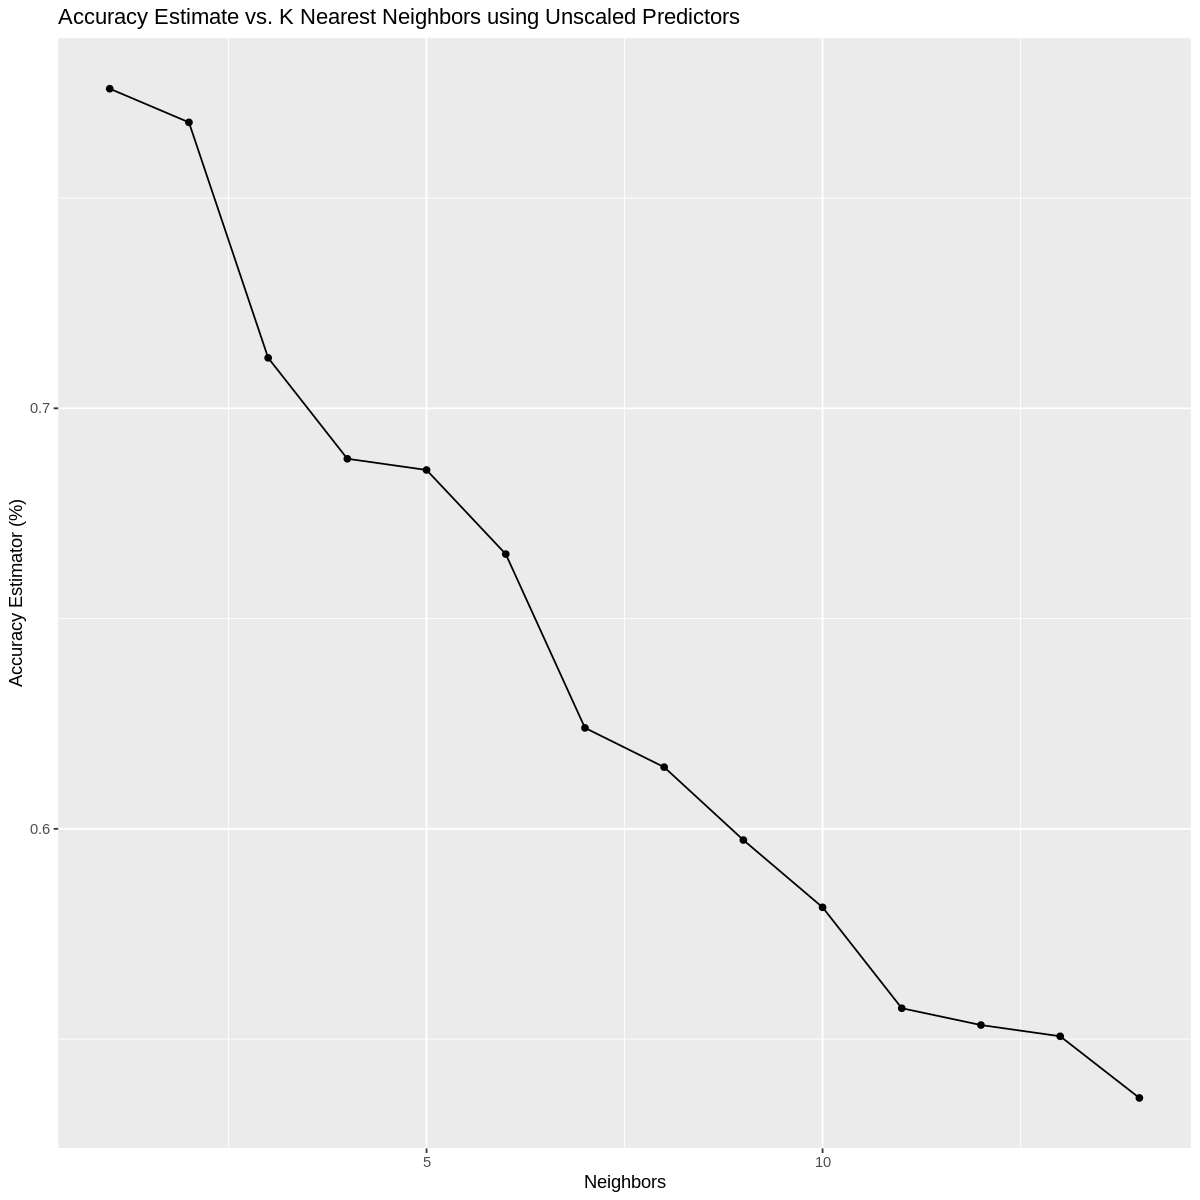

In [88]:
# Workflow using unscaled predictors

# create recipe
grades_recipe_unscaled <- recipe(grade_category ~., data = grades_train_predictors)

#obtain accuracy estimates based on 20 different values of k
grade_results_unscaled <- workflow() %>%
  add_recipe(grades_recipe_unscaled) %>%
  add_model(grades_knn_spec) %>%
  tune_grid(resamples = grades_vfold, grid = 20) %>% # grid = 10 indicates tuning should try 10 values for K
  collect_metrics()
grade_results_unscaled

# create plot of accuracy estimate vs. k nearest neighbors for unscaled data
grade_results_accuracies_plot_unscaled <- grade_results_unscaled %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors", y = "Accuracy Estimator (%)") +
    ggtitle("Accuracy Estimate vs. K Nearest Neighbors using Unscaled Predictors")

# print out plot
grade_results_accuracies_plot_unscaled

In [90]:
# create final model specification using k = 1 neighbor
grades_spec_final_unscaled <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>%
  set_engine("kknn") %>%
  set_mode("classification")

grades_fit_unscaled <- workflow() %>%
  add_recipe(grades_recipe) %>%
  add_model(grades_spec_final) %>%
  fit(data = grades_train_predictors)

# obtain grade_category prediction accuracy using testing dataset
grades_test_predictions_unscaled <- predict(grades_fit_unscaled, grades_test) %>%
  bind_cols(grades_test) %>%
  metrics(truth = grade_category, estimate = .pred_class)
grades_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.39175258
kap,multiclass,-0.02178182


Methods

We will be performing our data analysis by splitting our data into training and testing data based on the following 10 variables out of 30 and using them to predict the students' math grades. Since our primary focus when analyzing the data is on the possible correlation between a student's relationships with others and their grades, we narrowed down our variables to:

famsize - family size
Pstatus - parent's cohabitation status
Medu - mother's education
Fedu - father's education
romantic - romantic relationship
goout - going out with friends
famrel - quality of family relationships
freetime - free time after school
famsup - family educational support
paid - extra paid classes within the course subject
One of the ways plan to visualize the correlation between each of our 10 variables and the students' math grades is to generate ten different scatter plots - each one containing the Math grades on the y-axis and one of the 10 variables we chose on the x-axis.

Expected Outcomes and Significance

We are expecting to find a positive correlation between relationship and math grades. How healthy the relationships they have with those around them should reflect positively on their grades. Findings from this project would help us get a better understanding of the importance of work-life balance. Although the data is from a Portuguese high school, it should still be a good indicator that we can apply to our own lives. Future questions that may be worth pursuing after this project would be along the lines of which variables chosen have the strongest correlation with the results. i.e. Family support having a strong relationship while family size having a negligible relationship.